In [1]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt

from scipy.stats.stats import pearsonr

In [213]:
def plot_multiple_runs(folder, nb_shapes, nb_textures, nb_epoch, nb_trials):
    
    files = sorted([file for file in os.listdir(folder) if file.endswith('.csv')])
    dfs = [pd.read_csv(os.path.join(folder, file), index_col=False)
           for file in files]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4.5))
    colors = np.random.uniform(low=0, high=1, size=(len(dfs), 3))

    # vocab size 80% plot
    for i, df in enumerate(dfs):
        axes[0].plot(df.epoch, df.vocabSize80_s, label='shape', color=colors[i])
        #axes[0].plot(df.epoch, df.vocabSize80_t, label='texture', color=colors[i], linestyle='--')
    axes[0].set_xlabel('Epoch #', fontsize=16)
    axes[0].set_ylabel('Cumulative vocab size', fontsize=16)
    #axes[0].legend()
    
    # shape bias plot
    for i, df in enumerate(dfs):
        #o2_cumulative = np.asarray(list(itertools.accumulate(df.o2_correct)))
        #axes[1].plot(df.epoch, o2_cumulative, color=colors[i])
        axes[1].plot(df.epoch, df.o2_correct, color=colors[i])
    axes[1].set_xlabel('Epoch #', fontsize=16)
    axes[1].set_ylabel('# Shape choices', fontsize=16)
    
    # set plot limits
    axes[0].set_xlim(0, nb_epoch) # vocab x limits
    axes[1].set_xlim(0, nb_epoch) # shape x limits
    axes[0].set_ylim(0, nb_shapes+1) # vocab y limits
    axes[1].set_ylim(0, nb_trials) # shape y limits
    
    # turn off top and right spines
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    plt.subplots_adjust(wspace=0.5)
    plt.show()

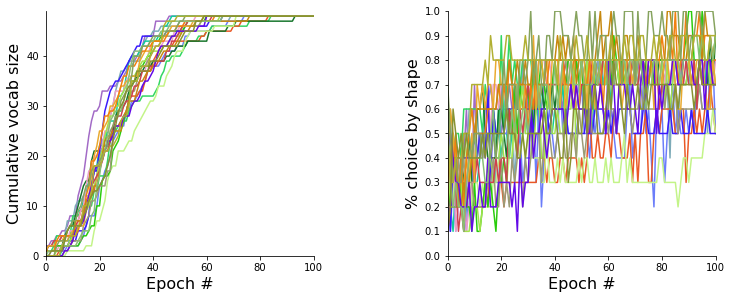

In [183]:
plot_multiple_runs('../results/vocab_accel_trio', nb_shapes=48, nb_textures=6)

In [234]:
import itertools

def plot(ax, df, vocab_start, vocab_end, nb_categories, plot_type, marker=None, marker_size=None):
    assert plot_type in ['vocab', 'shape']
    first_epoch = np.where(df.vocabSize80_s.values >= vocab_start*nb_categories)[0][0]
    last_epoch = np.where(df.vocabSize80_s.values <= vocab_end*nb_categories)[0][-1]
    if plot_type == 'vocab':
        vocab = \
        (df.vocabSize80_s.iloc[last_epoch] - df.vocabSize80_s.iloc[first_epoch]) / (last_epoch - first_epoch)
        ax.plot(
            [e-first_epoch for e in df.epoch[first_epoch:last_epoch]], 
            df.vocabSize80_s[first_epoch:last_epoch],
            label='%0.3f' % vocab
        )
        return (last_epoch - first_epoch), df.vocabSize80_s[last_epoch]
    else:
        shape = df.o2_correct.values[first_epoch:last_epoch+1].mean()
        o2_cumulative = np.asarray(list(itertools.accumulate(df.o2_correct)))
        ax.plot(
            [e-first_epoch for e in df.epoch[first_epoch:last_epoch]], 
            o2_cumulative[first_epoch:last_epoch],
            label='%0.3f' % shape
        )
        return o2_cumulative, o2_cumulative[last_epoch]

def plot_first100nouns(
    folder, nb_categories, nb_epoch, vocab_start=0.1, 
    vocab_end=0.5, axis_fs=20, tick_fs=15, marker_size=70
):
    files = sorted([file for file in os.listdir(folder) if file.endswith('.csv')])
    dfs = [pd.read_csv(os.path.join(folder, file), index_col=False)
           for file in files]
    #dfs = dfs[:5]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    # vocab size 80% plot
    x_max = 0
    y_max = 0
    for df, marker in zip(dfs, itertools.cycle('o^+*s')):
        if not len(df) >= nb_epoch:
            continue
        epoch_range, final_vs = plot(
            axes[0], df, vocab_start, vocab_end, nb_categories,
            'vocab', marker, marker_size
        )
        y_max = max(y_max, final_vs)
        x_max = max(x_max, epoch_range)
    axes[0].set_xlabel('Epoch #', fontsize=axis_fs)
    axes[0].set_ylabel('Cumulative vocab size', fontsize=axis_fs)
    
    
    # shape bias plot
    y_max1 = 0
    for df, marker in zip(dfs, itertools.cycle('o^+*s')):
        if not len(df) >= nb_epoch:
            continue
        o2_cumulative, o2_max = plot(
            axes[1], df, vocab_start, vocab_end, nb_categories,
            'shape', marker, marker_size
        )
        y_max1 = max(y_max1, o2_max)
    axes[1].set_xlabel('Epoch #', fontsize=axis_fs)
    axes[1].set_ylabel('Cumulative shape choices', fontsize=axis_fs)
    
    # Set limits
    axes[0].set_xlim(0, x_max+2) # vocab epoch limits
    axes[1].set_xlim(0, x_max+2) # shape epoch limits
    axes[0].set_ylim(0, y_max+3) # vocab y limits
    axes[1].set_ylim(0, y_max1+5) # shape y limits
    # Plot legends
    axes[0].legend()
    axes[1].legend()
    # Turn off top and right spines
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=0.5)
    plt.show()

In [138]:
def compute_correlation(folder, nb_categories, nb_epoch, vocab_start=0.1, vocab_end=0.5):
    files = sorted([file for file in os.listdir(folder) if file.endswith('.csv')])
    dfs = [pd.read_csv(os.path.join(folder, file), index_col=False)
           for file in files]
    shape_choices = []
    vocab_slopes = []
    for i, df in enumerate(dfs):
        if not len(df) >= nb_epoch:
            continue
        first_epoch = np.where(df.vocabSize80_s.values >= vocab_start*nb_categories)[0][0]
        last_epoch = np.where(df.vocabSize80_s.values <= vocab_end*nb_categories)[0][-1]
        shape = df.o2_correct.values[first_epoch:last_epoch+1].mean()
        vocab = \
        (df.vocabSize80_s.iloc[last_epoch] - df.vocabSize80_s.iloc[first_epoch]) / (last_epoch - first_epoch)
        shape_choices.append(shape)
        vocab_slopes.append(vocab)
        
    return np.asarray(shape_choices), np.asarray(vocab_slopes)

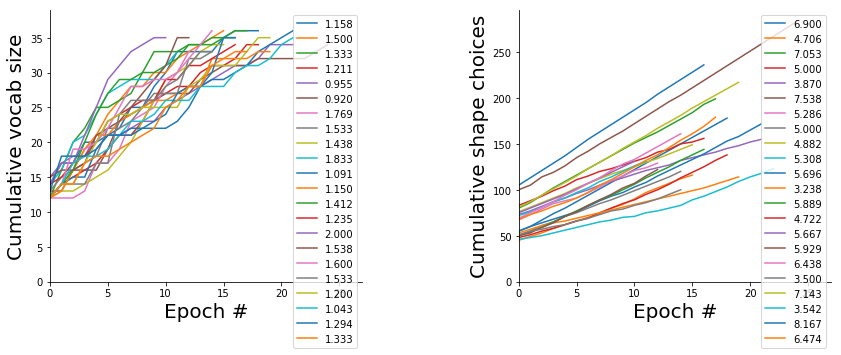

In [179]:
plot_first100nouns(
    '../results/vocab_accel_trio/', 
    nb_categories=48,
    nb_epoch=100,
    vocab_start=0.25,
    vocab_end=0.75
)

correlation: -0.1092
p-value: 0.6287


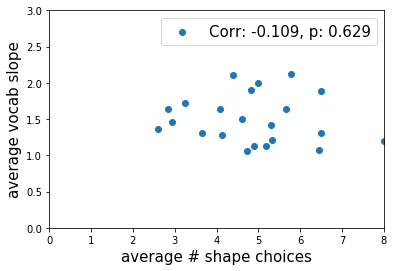

In [180]:
shape_choices, vocab_slopes = compute_correlation(
    '../results/vocab_accel_trio',
    nb_categories=48,
    nb_epoch=100,
    vocab_start=0.1,
    vocab_end=0.5
)

corr, p = pearsonr(shape_choices, vocab_slopes)
print('correlation: %0.4f' % corr)
print('p-value: %0.4f' % p)

plt.figure(figsize=(6,4))
plt.scatter(shape_choices, vocab_slopes, label='Corr: %0.3f, p: %0.3f' % (corr, p))
plt.xlabel('average # shape choices', fontsize=15)
plt.ylabel('average vocab slope', fontsize=15)
plt.xlim(0, 8)
plt.ylim(0, 3)
plt.legend(fontsize=15)
plt.show()

In [185]:
for start in [0, 0.05, 0.1, 0.15, 0.2, 0.25]:
    for end in [0.5, 0.6, 0.7, 0.8, 0.9]:
        shape_choices, vocab_slopes = compute_correlation(
            '../results/vocab_accel_trio/',
            nb_categories=48,
            nb_epoch=100,
            vocab_start=start,
            vocab_end=end
        )
        corr, p = pearsonr(shape_choices, vocab_slopes)
        print('start: %0.2f, end: %0.2f' % (start, end))
        print('correlation: %0.4f' % corr)
        print('p-value: %0.4f\n' % p)

start: 0.00, end: 0.50
correlation: 0.0363
p-value: 0.8725

start: 0.00, end: 0.60
correlation: 0.1006
p-value: 0.6560

start: 0.00, end: 0.70
correlation: 0.0645
p-value: 0.7754

start: 0.00, end: 0.80
correlation: 0.0020
p-value: 0.9929

start: 0.00, end: 0.90
correlation: 0.0162
p-value: 0.9429

start: 0.05, end: 0.50
correlation: -0.2650
p-value: 0.2334

start: 0.05, end: 0.60
correlation: -0.1826
p-value: 0.4159

start: 0.05, end: 0.70
correlation: -0.1720
p-value: 0.4440

start: 0.05, end: 0.80
correlation: -0.2225
p-value: 0.3196

start: 0.05, end: 0.90
correlation: -0.1547
p-value: 0.4918

start: 0.10, end: 0.50
correlation: -0.1092
p-value: 0.6287

start: 0.10, end: 0.60
correlation: -0.0252
p-value: 0.9113

start: 0.10, end: 0.70
correlation: -0.0354
p-value: 0.8758

start: 0.10, end: 0.80
correlation: -0.1038
p-value: 0.6458

start: 0.10, end: 0.90
correlation: -0.0589
p-value: 0.7947

start: 0.15, end: 0.50
correlation: 0.0506
p-value: 0.8231

start: 0.15, end: 0.60
correla

## vocab_accel_trio_batch10: 80-10-10 breakdown, 60 categories (total), 10 exemplars, batch_size=10, nb_test=10

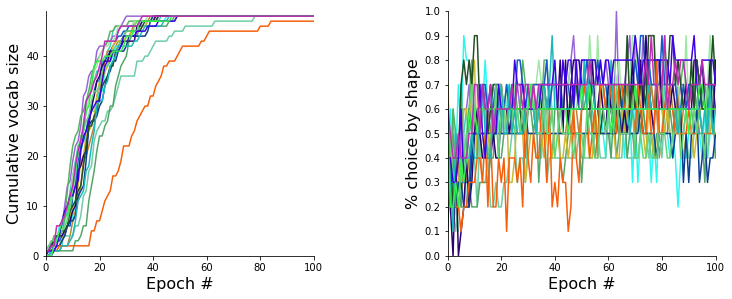

In [186]:
plot_multiple_runs('../results/vocab_accel_trio_batch10/', nb_shapes=48, nb_textures=6)

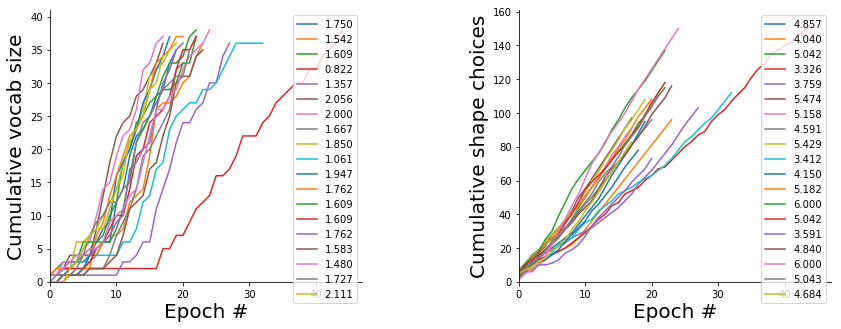

In [194]:
plot_first100nouns(
    '../results/vocab_accel_trio_batch10/', 
    nb_categories=48,
    nb_epoch=100,
    vocab_start=0.0,
    vocab_end=0.8
)

correlation: 0.5059
p-value: 0.0271


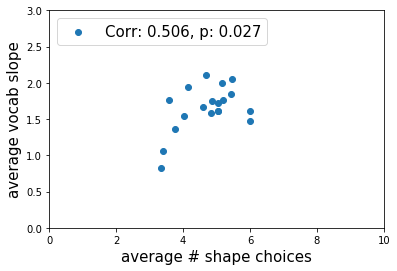

In [195]:
shape_choices, vocab_slopes = compute_correlation(
    '../results/vocab_accel_trio_batch10/',
    nb_categories=48,
    nb_epoch=100,
    vocab_start=0.0,
    vocab_end=0.8
)

corr, p = pearsonr(shape_choices, vocab_slopes)
print('correlation: %0.4f' % corr)
print('p-value: %0.4f' % p)

plt.figure(figsize=(6,4))
plt.scatter(shape_choices, vocab_slopes, label='Corr: %0.3f, p: %0.3f' % (corr, p))
plt.xlabel('average # shape choices', fontsize=15)
plt.ylabel('average vocab slope', fontsize=15)
plt.xlim(0, 10)
plt.ylim(0, 3)
plt.legend(fontsize=15, loc='upper left')
plt.show()

In [198]:
for start in [0, 0.05, 0.1, 0.15, 0.2, 0.25]:
    for end in [0.6, 0.7, 0.8, 0.9]:
        shape_choices, vocab_slopes = compute_correlation(
            '../results/vocab_accel_trio_batch10/',
            nb_categories=48,
            nb_epoch=100,
            vocab_start=start,
            vocab_end=end
        )
        corr, p = pearsonr(shape_choices, vocab_slopes)
        print('start: %0.2f, end: %0.2f' % (start, end))
        print('correlation: %0.4f' % corr)
        print('p-value: %0.4f\n' % p)

start: 0.00, end: 0.60
correlation: 0.5088
p-value: 0.0261

start: 0.00, end: 0.70
correlation: 0.4774
p-value: 0.0388

start: 0.00, end: 0.80
correlation: 0.5059
p-value: 0.0271

start: 0.00, end: 0.90
correlation: 0.6927
p-value: 0.0010

start: 0.05, end: 0.60
correlation: 0.3317
p-value: 0.1654

start: 0.05, end: 0.70
correlation: 0.3166
p-value: 0.1866

start: 0.05, end: 0.80
correlation: 0.3598
p-value: 0.1302

start: 0.05, end: 0.90
correlation: 0.5153
p-value: 0.0239

start: 0.10, end: 0.60
correlation: 0.2359
p-value: 0.3310

start: 0.10, end: 0.70
correlation: 0.2817
p-value: 0.2427

start: 0.10, end: 0.80
correlation: 0.3761
p-value: 0.1125

start: 0.10, end: 0.90
correlation: 0.5365
p-value: 0.0179

start: 0.15, end: 0.60
correlation: 0.3386
p-value: 0.1562

start: 0.15, end: 0.70
correlation: 0.3337
p-value: 0.1626

start: 0.15, end: 0.80
correlation: 0.4681
p-value: 0.0433

start: 0.15, end: 0.90
correlation: 0.5790
p-value: 0.0094

start: 0.20, end: 0.60
correlation: 0.50

## redo vocab_accel_trio_batch10 one more time to see if we can replicate results

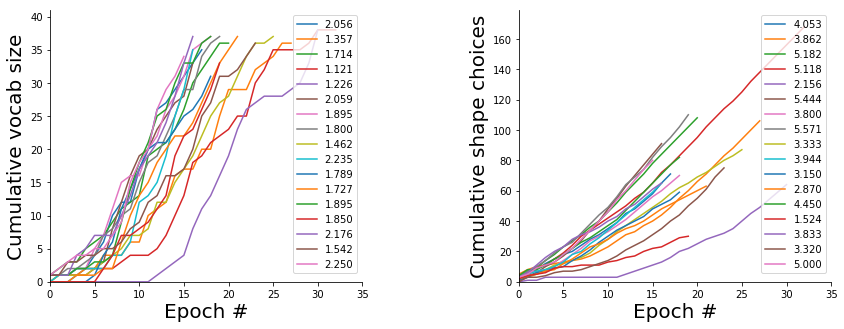

In [328]:
plot_first100nouns(
    '../results/vocab_accel_trio_batch10_redo/', 
    nb_categories=48,
    nb_epoch=100,
    vocab_start=0.0,
    vocab_end=0.8
)

correlation: 0.2198
p-value: 0.3966


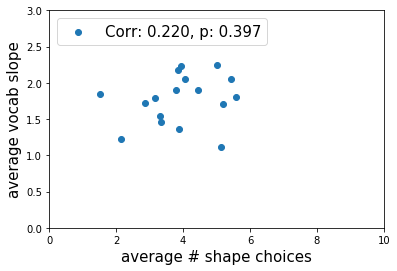

In [329]:
shape_choices, vocab_slopes = compute_correlation(
    '../results/vocab_accel_trio_batch10_redo/',
    nb_categories=48,
    nb_epoch=100,
    vocab_start=0.0,
    vocab_end=0.8
)

corr, p = pearsonr(shape_choices, vocab_slopes)
print('correlation: %0.4f' % corr)
print('p-value: %0.4f' % p)

plt.figure(figsize=(6,4))
plt.scatter(shape_choices, vocab_slopes, label='Corr: %0.3f, p: %0.3f' % (corr, p))
plt.xlabel('average # shape choices', fontsize=15)
plt.ylabel('average vocab slope', fontsize=15)
plt.xlim(0, 10)
plt.ylim(0, 3)
plt.legend(fontsize=15, loc='upper left')
plt.show()

In [330]:
for start in [0, 0.05, 0.1, 0.15, 0.2, 0.25]:
    for end in [0.6, 0.7, 0.8, 0.9]:
        shape_choices, vocab_slopes = compute_correlation(
            '../results/vocab_accel_trio_batch10_redo/',
            nb_categories=48,
            nb_epoch=100,
            vocab_start=start,
            vocab_end=end
        )
        corr, p = pearsonr(shape_choices, vocab_slopes)
        print('start: %0.2f, end: %0.2f' % (start, end))
        print('correlation: %0.4f' % corr)
        print('p-value: %0.4f\n' % p)

start: 0.00, end: 0.60
correlation: 0.3820
p-value: 0.1302

start: 0.00, end: 0.70
correlation: 0.4064
p-value: 0.1055

start: 0.00, end: 0.80
correlation: 0.2198
p-value: 0.3966

start: 0.00, end: 0.90
correlation: 0.1907
p-value: 0.4636

start: 0.05, end: 0.60
correlation: 0.2522
p-value: 0.3288

start: 0.05, end: 0.70
correlation: 0.2671
p-value: 0.3000

start: 0.05, end: 0.80
correlation: 0.1086
p-value: 0.6783

start: 0.05, end: 0.90
correlation: 0.0837
p-value: 0.7493

start: 0.10, end: 0.60
correlation: 0.2665
p-value: 0.3011

start: 0.10, end: 0.70
correlation: 0.2865
p-value: 0.2648

start: 0.10, end: 0.80
correlation: 0.1217
p-value: 0.6418

start: 0.10, end: 0.90
correlation: 0.0973
p-value: 0.7103

start: 0.15, end: 0.60
correlation: 0.2865
p-value: 0.2650

start: 0.15, end: 0.70
correlation: 0.2561
p-value: 0.3210

start: 0.15, end: 0.80
correlation: 0.0686
p-value: 0.7936

start: 0.15, end: 0.90
correlation: 0.0113
p-value: 0.9656

start: 0.20, end: 0.60
correlation: 0.13

In [ ]:
# vocab_accel_trio_500trials: 80-10-10 breakdown, 60 categories (total), 10 exemplars,
# batch_size=10, nb_test=500

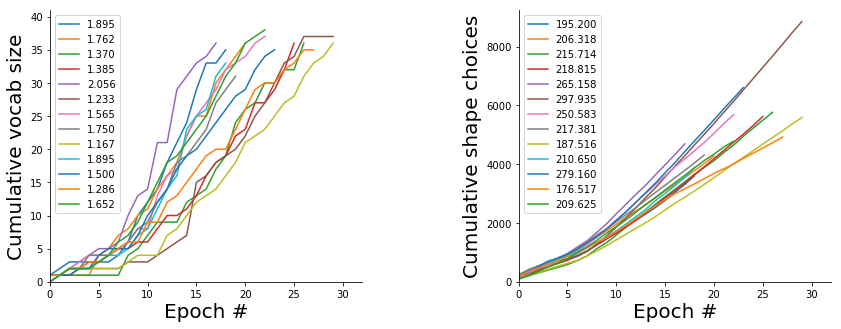

In [199]:
plot_first100nouns(
    '../results/vocab_accel_trio_500trials', 
    nb_categories=48,
    nb_epoch=70,
    vocab_start=0.0,
    vocab_end=0.8
)

correlation: 0.0187
p-value: 0.9515


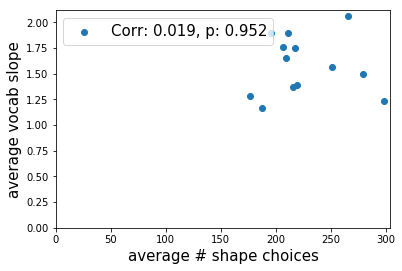

In [204]:
shape_choices, vocab_slopes = compute_correlation(
    '../results/vocab_accel_trio_500trials/',
    nb_categories=48,
    nb_epoch=70,
    vocab_start=0.0,
    vocab_end=0.8
)

corr, p = pearsonr(shape_choices, vocab_slopes)
print('correlation: %0.4f' % corr)
print('p-value: %0.4f' % p)

plt.figure(figsize=(6,4))
plt.scatter(shape_choices, vocab_slopes, label='Corr: %0.3f, p: %0.3f' % (corr, p))
plt.xlabel('average # shape choices', fontsize=15)
plt.ylabel('average vocab slope', fontsize=15)
plt.xlim(0)
plt.ylim(0)
plt.legend(fontsize=15, loc='upper left')
plt.show()

In [205]:
for start in [0, 0.05, 0.1, 0.15, 0.2, 0.25]:
    for end in [0.6, 0.7, 0.8, 0.9]:
        shape_choices, vocab_slopes = compute_correlation(
            '../results/vocab_accel_trio_500trials/',
            nb_categories=48,
            nb_epoch=70,
            vocab_start=start,
            vocab_end=end
        )
        corr, p = pearsonr(shape_choices, vocab_slopes)
        print('start: %0.2f, end: %0.2f' % (start, end))
        print('correlation: %0.4f' % corr)
        print('p-value: %0.4f\n' % p)

start: 0.00, end: 0.60
correlation: -0.0182
p-value: 0.9529

start: 0.00, end: 0.70
correlation: 0.1079
p-value: 0.7258

start: 0.00, end: 0.80
correlation: 0.0187
p-value: 0.9515

start: 0.00, end: 0.90
correlation: -0.1090
p-value: 0.7229

start: 0.05, end: 0.60
correlation: 0.0976
p-value: 0.7512

start: 0.05, end: 0.70
correlation: 0.1337
p-value: 0.6632

start: 0.05, end: 0.80
correlation: -0.0280
p-value: 0.9276

start: 0.05, end: 0.90
correlation: -0.1898
p-value: 0.5346

start: 0.10, end: 0.60
correlation: 0.0613
p-value: 0.8423

start: 0.10, end: 0.70
correlation: 0.1900
p-value: 0.5341

start: 0.10, end: 0.80
correlation: 0.0243
p-value: 0.9372

start: 0.10, end: 0.90
correlation: -0.1114
p-value: 0.7170

start: 0.15, end: 0.60
correlation: -0.0101
p-value: 0.9740

start: 0.15, end: 0.70
correlation: 0.1720
p-value: 0.5741

start: 0.15, end: 0.80
correlation: 0.0066
p-value: 0.9828

start: 0.15, end: 0.90
correlation: -0.1702
p-value: 0.5783

start: 0.20, end: 0.60
correlatio

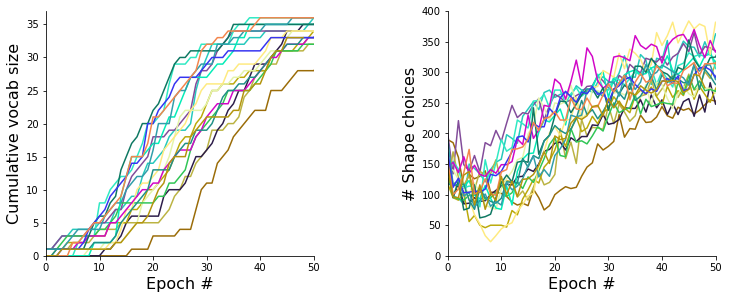

In [223]:
plot_multiple_runs('../results/vocab_accel_trio_602020/', nb_shapes=36, 
                   nb_textures=12, nb_epoch=50, nb_trials=400)

In [280]:
def plot_first100nouns_separate(
    folder, nb_categories, nb_epoch, nb_trials, vocab_start=0., 
    vocab_end=0.5, axis_fs=20, tick_fs=15, marker_size=70
):
    
    files = sorted([file for file in os.listdir(folder) if file.endswith('.csv')])
    for file in files:
        df = pd.read_csv(os.path.join(folder, file), index_col=False)
        if not len(df) >= nb_epoch:
            continue
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
        
        # compute start and end epoch
        first_epoch = np.where(df.vocabSize80_s.values >= vocab_start*nb_categories)[0][0]
        last_epoch = np.where(df.vocabSize80_s.values <= vocab_end*nb_categories)[0][-1]
        print('first_epoch: %i' % first_epoch)
        print('last_epoch: %i' % last_epoch)
        # compute vocab slope and avg # shape choices
        vocab = \
        (df.vocabSize80_s.iloc[last_epoch] - df.vocabSize80_s.iloc[first_epoch]) / (last_epoch - first_epoch)
        shape = df.o2_correct.values[first_epoch:last_epoch+1].mean()
        
        # vocab size 80% plot
        axes[0].plot(df.epoch.values, df.vocabSize80_s, label='%0.3f' % vocab)
        axes[0].scatter(
            [first_epoch, last_epoch], 
            [df.vocabSize80_s.iloc[first_epoch], df.vocabSize80_s.iloc[last_epoch]], 
            s=marker_size
        )
        axes[0].plot(
            [first_epoch, last_epoch], 
            [df.vocabSize80_s.iloc[first_epoch], df.vocabSize80_s.iloc[last_epoch]], 
            linestyle='--'
        )
        axes[0].set_xlim(0, nb_epoch)
        axes[0].set_ylim(0, nb_categories)
        axes[0].set_xlabel('Epoch #', fontsize=axis_fs)
        axes[0].set_ylabel('Cumulative vocab size', fontsize=axis_fs)
        
        # shape bias plot
        o2_cumulative = np.asarray(list(itertools.accumulate(df.o2_correct)))
        axes[1].plot(df.epoch.values, df.o2_correct.values, label='%0.3f' % shape)
        axes[1].scatter(
            [first_epoch, last_epoch], 
            [df.o2_correct.iloc[first_epoch], df.o2_correct.iloc[last_epoch]], 
            s=marker_size
        )
        axes[1].plot(
            np.linspace(0, nb_epoch, 50),
            [shape]*50,
            linestyle='--'
        )
        axes[1].set_xlim(0, nb_epoch)
        axes[1].set_ylim(0, nb_trials)
        axes[1].set_xlabel('Epoch #', fontsize=axis_fs)
        axes[1].set_ylabel('Cumulative shape choices', fontsize=axis_fs)
    
        # Plot legends
        axes[0].legend(fontsize=15)
        axes[1].legend(fontsize=15)
        # Turn off top and right spines
        axes[0].spines['right'].set_visible(False)
        axes[0].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)
        axes[1].spines['top'].set_visible(False)

        plt.subplots_adjust(wspace=0.5)
        plt.show()

correlation: -0.1145
p-value: 0.6617


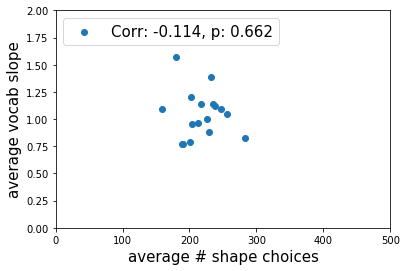

In [282]:
shape_choices, vocab_slopes = compute_correlation(
    '../results/vocab_accel_trio_602020/',
    nb_categories=36,
    nb_epoch=70,
    vocab_start=0.1,
    vocab_end=0.8
)

corr, p = pearsonr(shape_choices, vocab_slopes)
print('correlation: %0.4f' % corr)
print('p-value: %0.4f' % p)

plt.figure(figsize=(6,4))
plt.scatter(shape_choices, vocab_slopes, label='Corr: %0.3f, p: %0.3f' % (corr, p))
plt.xlabel('average # shape choices', fontsize=15)
plt.ylabel('average vocab slope', fontsize=15)
plt.xlim(0, 500)
plt.ylim(0, 2)
plt.legend(fontsize=15, loc='upper left')
plt.show()

first_epoch: 0
last_epoch: 50


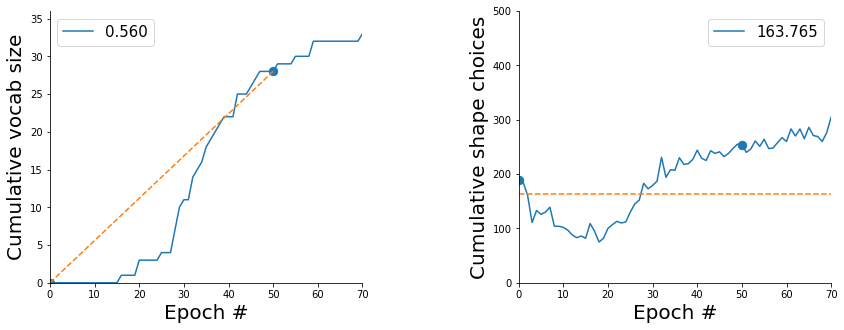

first_epoch: 0
last_epoch: 29


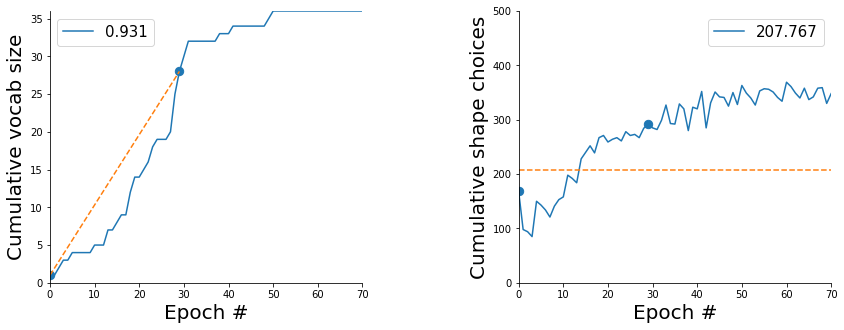

first_epoch: 0
last_epoch: 30


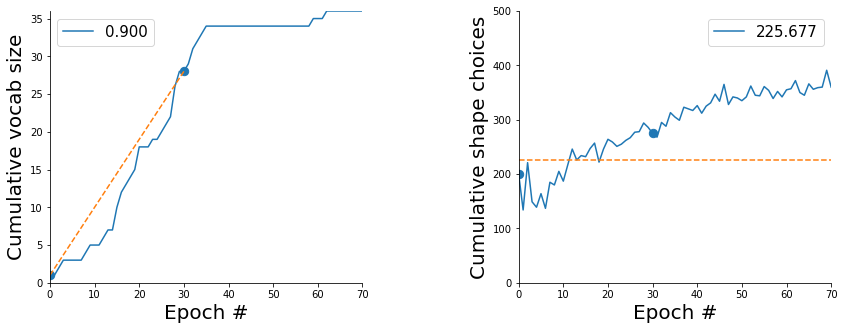

first_epoch: 0
last_epoch: 41


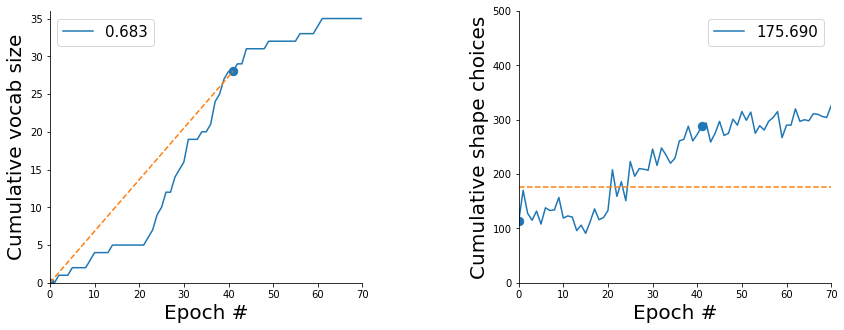

first_epoch: 0
last_epoch: 38


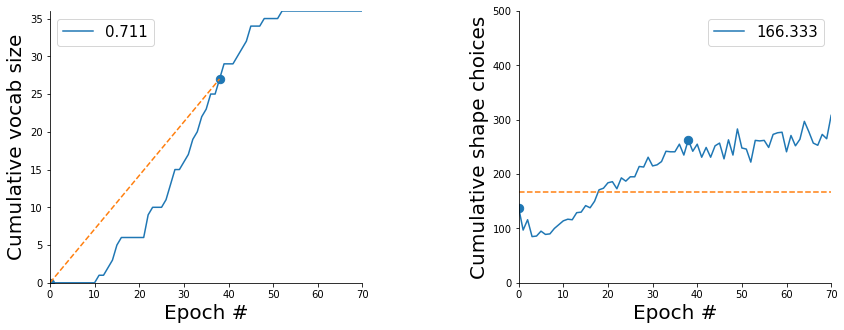

first_epoch: 0
last_epoch: 23


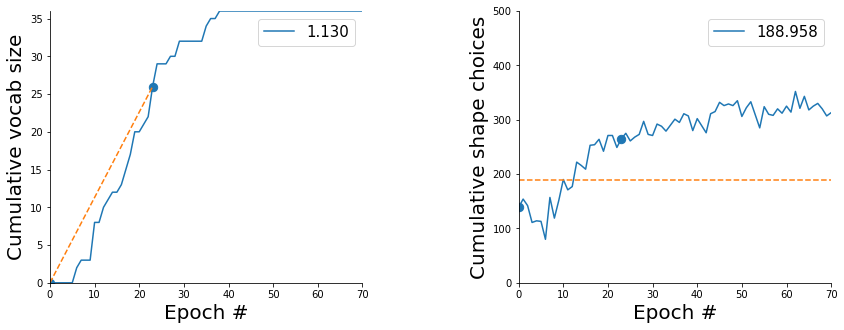

first_epoch: 0
last_epoch: 41


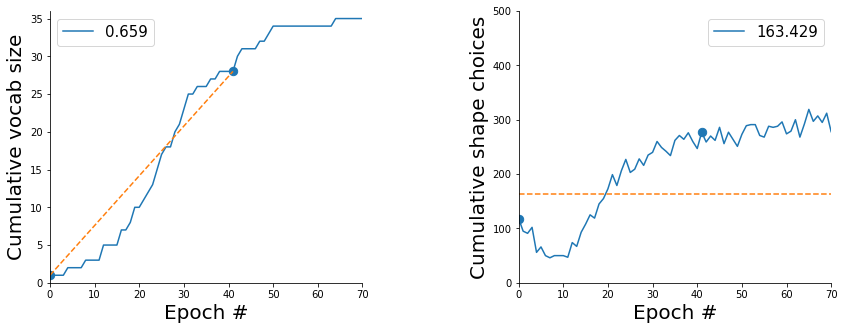

first_epoch: 0
last_epoch: 39


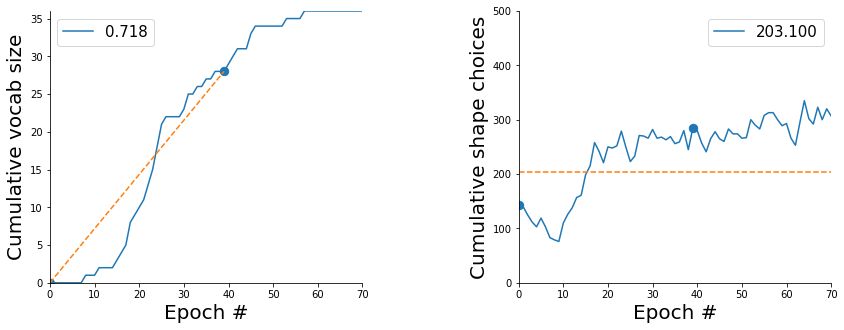

first_epoch: 0
last_epoch: 41


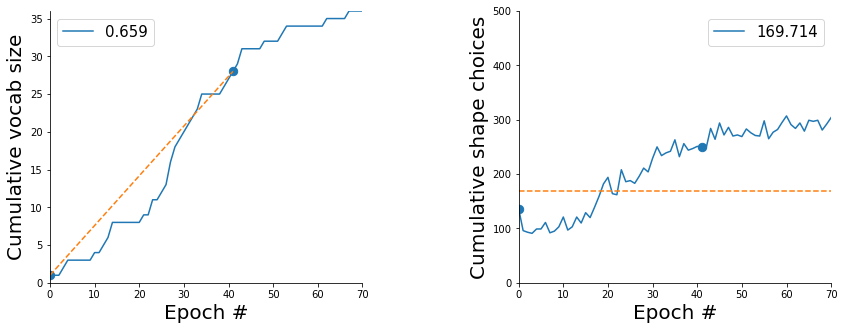

first_epoch: 0
last_epoch: 31


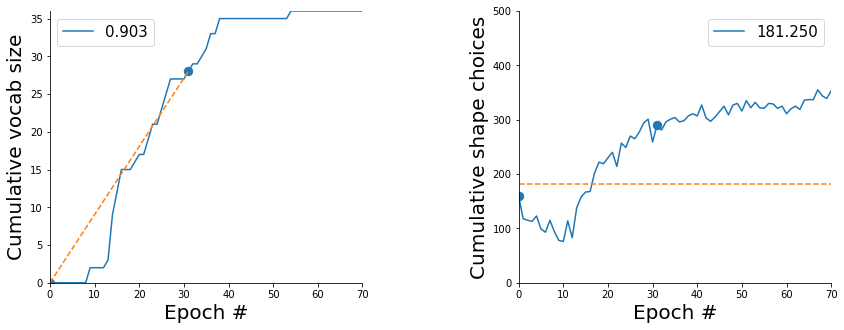

first_epoch: 0
last_epoch: 35


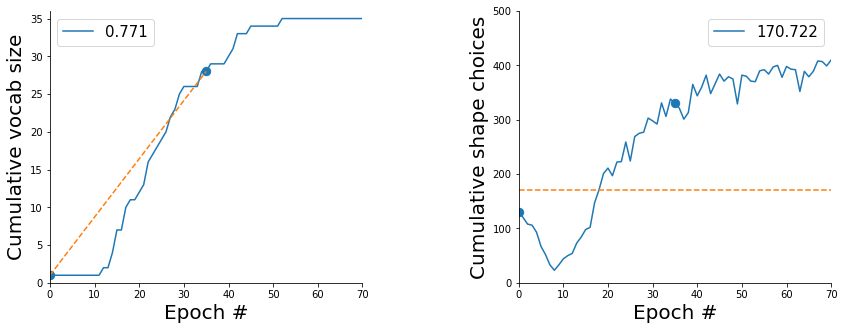

first_epoch: 0
last_epoch: 40


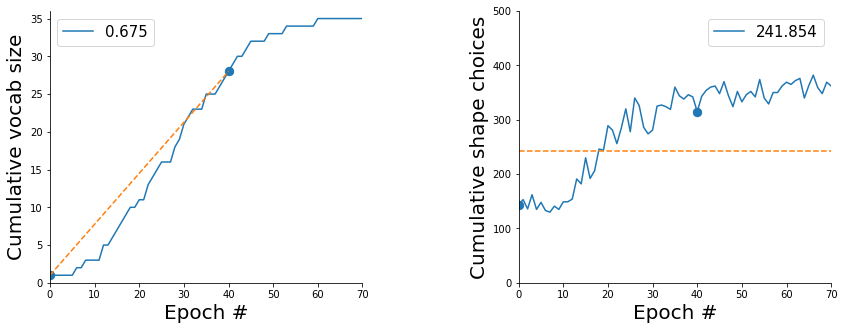

first_epoch: 0
last_epoch: 23


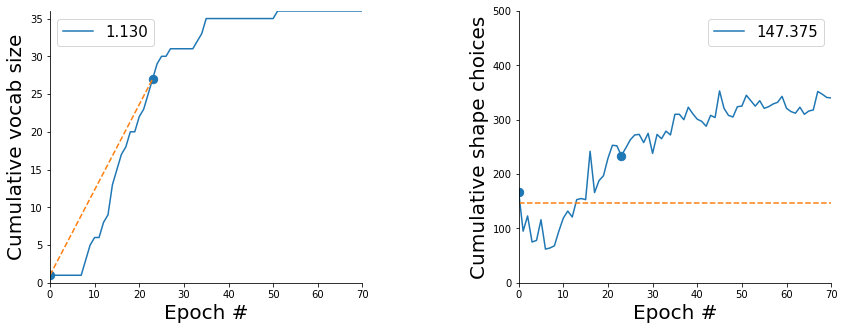

first_epoch: 0
last_epoch: 40


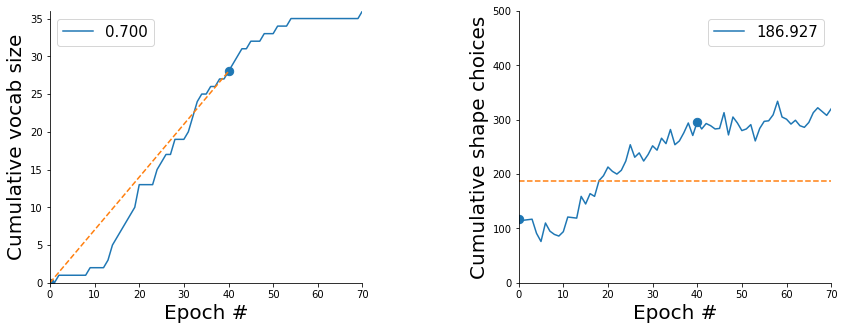

first_epoch: 0
last_epoch: 28


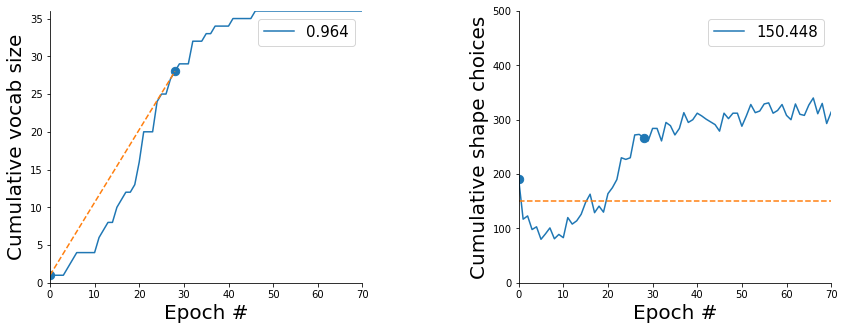

first_epoch: 0
last_epoch: 29


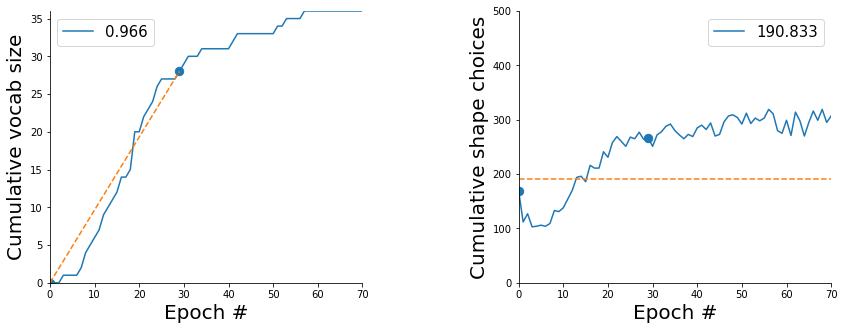

first_epoch: 0
last_epoch: 28


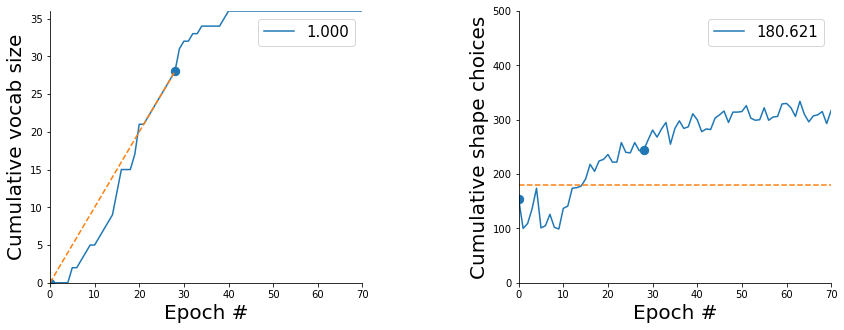

first_epoch: 0
last_epoch: 41


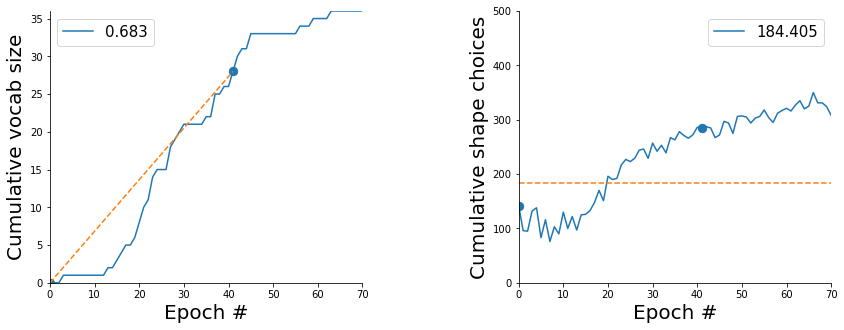

first_epoch: 0
last_epoch: 29


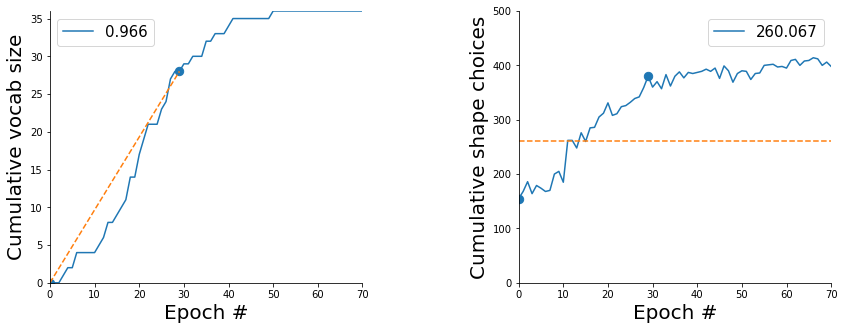

first_epoch: 0
last_epoch: 28


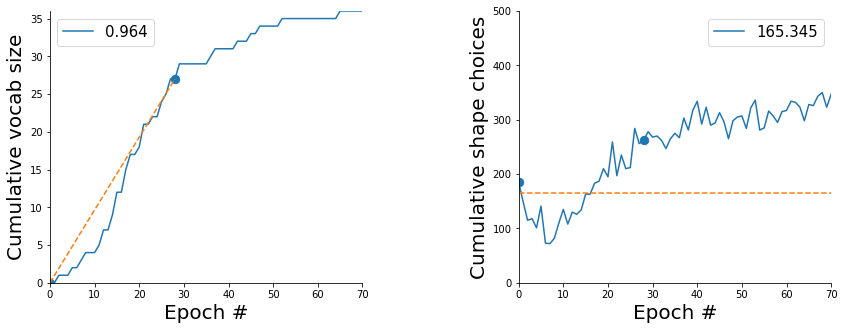

In [332]:
plot_first100nouns_separate(
    folder='../results/vocab_accel_trio_602020', 
    nb_categories=36,
    nb_epoch=70,
    nb_trials=500,
    vocab_start=0.,
    vocab_end=0.8
)

In [283]:
from scipy.stats import binom

In [293]:
binom.pmf(k=4, n=10, p=0.3333)

0.22758481426645963

In [523]:
180*3

540

In [524]:
nb_test = 1000
probs = [1. - binom.cdf(k=i, n=nb_test, p=1/3.) for i in range(nb_test+1)]
list(enumerate(probs))

[(0, 1.0),
 (1, 1.0),
 (2, 1.0),
 (3, 1.0),
 (4, 1.0),
 (5, 1.0),
 (6, 1.0),
 (7, 1.0),
 (8, 1.0),
 (9, 1.0),
 (10, 1.0),
 (11, 1.0),
 (12, 1.0),
 (13, 1.0),
 (14, 1.0),
 (15, 1.0),
 (16, 1.0),
 (17, 1.0),
 (18, 1.0),
 (19, 1.0),
 (20, 1.0),
 (21, 1.0),
 (22, 1.0),
 (23, 1.0),
 (24, 1.0),
 (25, 1.0),
 (26, 1.0),
 (27, 1.0),
 (28, 1.0),
 (29, 1.0),
 (30, 1.0),
 (31, 1.0),
 (32, 1.0),
 (33, 1.0),
 (34, 1.0),
 (35, 1.0),
 (36, 1.0),
 (37, 1.0),
 (38, 1.0),
 (39, 1.0),
 (40, 1.0),
 (41, 1.0),
 (42, 1.0),
 (43, 1.0),
 (44, 1.0),
 (45, 1.0),
 (46, 1.0),
 (47, 1.0),
 (48, 1.0),
 (49, 1.0),
 (50, 1.0),
 (51, 1.0),
 (52, 1.0),
 (53, 1.0),
 (54, 1.0),
 (55, 1.0),
 (56, 1.0),
 (57, 1.0),
 (58, 1.0),
 (59, 1.0),
 (60, 1.0),
 (61, 1.0),
 (62, 1.0),
 (63, 1.0),
 (64, 1.0),
 (65, 1.0),
 (66, 1.0),
 (67, 1.0),
 (68, 1.0),
 (69, 1.0),
 (70, 1.0),
 (71, 1.0),
 (72, 1.0),
 (73, 1.0),
 (74, 1.0),
 (75, 1.0),
 (76, 1.0),
 (77, 1.0),
 (78, 1.0),
 (79, 1.0),
 (80, 1.0),
 (81, 1.0),
 (82, 1.0),
 (83, 1.0),
 (

# Let's retry the correlation study a different way... set starting point (epoch 0), set end point.

In [621]:
import itertools

def plot_first100nouns_new(folder, nb_categories, nb_epoch, nb_test, file_inds=None, axis_fs=20, 
                           tick_fs=15, marker_size=70):
    
    files = sorted([file for file in os.listdir(folder) if file.endswith('.csv')])
    if file_inds is not None:
        files = [files[i] for i in file_inds]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    max_o2 = 0
    shape_choices = []
    vocab_slopes = []
    for i, file in enumerate(files):
        df = pd.read_csv(os.path.join(folder, file), index_col=False)
        if not len(df) >= nb_epoch:
            continue
        o2_cumulative = np.asarray(list(itertools.accumulate(df.o2_correct)))
        vocab = (df.vocabSize80_s.iloc[nb_epoch] - df.vocabSize80_s.iloc[0]) / nb_epoch
        shape = (o2_cumulative[nb_epoch] - o2_cumulative[0]) / nb_epoch
        vocab_slopes.append(vocab)
        shape_choices.append(shape)
        max_o2 = max(max_o2, np.max(o2_cumulative[:nb_epoch]))
        axes[0].plot(range(nb_epoch), df.vocabSize80_s.iloc[:nb_epoch])
        axes[1].plot(range(nb_epoch), o2_cumulative[:nb_epoch])
    axes[0].set_xlabel('Epoch #', fontsize=axis_fs)
    axes[0].set_ylabel('Cumulative vocab size', fontsize=axis_fs)
    axes[1].set_xlabel('Epoch #', fontsize=axis_fs)
    axes[1].set_ylabel('Cumulative shape choices', fontsize=axis_fs)
    # Set limits
    axes[0].set_xlim(0, nb_epoch+1) # vocab epoch limits
    axes[1].set_xlim(0, nb_epoch+1) # shape epoch limits
    axes[0].set_ylim(0, nb_categories+2) # vocab y limits
    axes[1].set_ylim(0, max_o2+5) # shape y limits
    # Turn off top and right spines
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    #plt.subplots_adjust(wspace=0.5)
    plt.show()
    
    # Compute correlation and plot
    corr, p = pearsonr(shape_choices, vocab_slopes)
    plt.figure(figsize=(6,4))
    plt.scatter(shape_choices, vocab_slopes, label='Corr: %0.3f, p: %0.3f' % (corr, p))
    plt.xlabel('average # shape choices', fontsize=15)
    plt.ylabel('average vocab slope', fontsize=15)
    plt.xlim(0, nb_test)
    plt.ylim(0, 4)
    plt.legend(fontsize=15, loc='upper left')
    plt.show()
    
    return np.asarray(vocab_slopes), np.asarray(shape_choices)

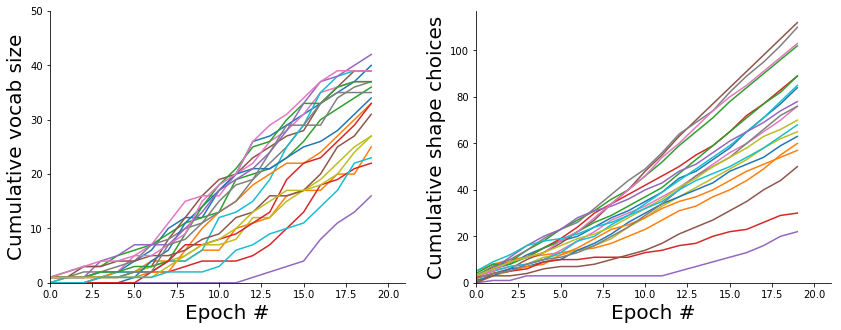

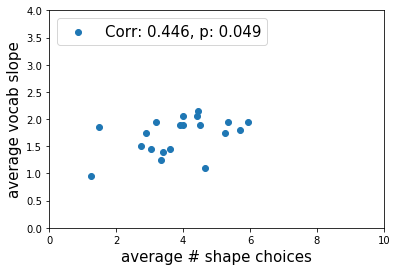

In [384]:
vocab_slopes, shape_choices = plot_first100nouns_new(
    folder='../results/vocab_accel_trio_batch10_redo/', 
    nb_categories=48,
    nb_epoch=20,
    nb_test=10
)

## Try this with other dataset of same parameters...

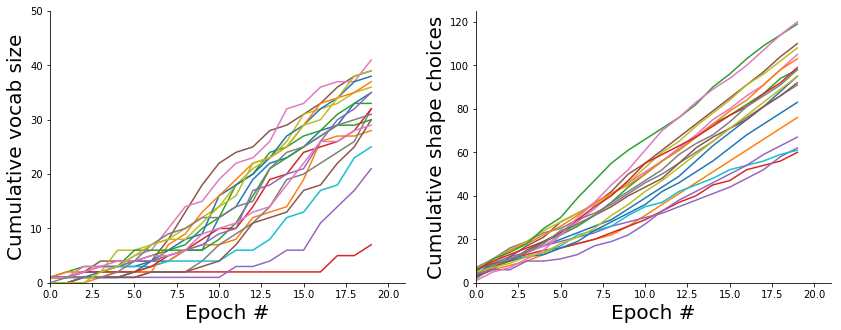

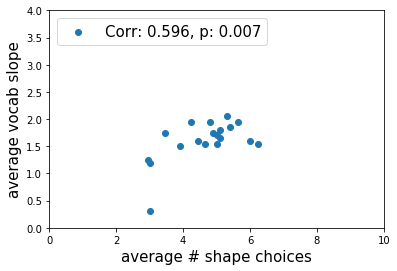

In [385]:
vocab_slopes, shape_choices = plot_first100nouns_new(
    folder='../results/vocab_accel_trio_batch10/', 
    nb_categories=48,
    nb_epoch=20,
    nb_test=10
)

# Try again with the 500-trial dataset

In [ ]:
# vocab_accel_trio_500trials: 80-10-10 breakdown, 60 categories (total), 10 exemplars,
# batch_size=10, nb_test=500

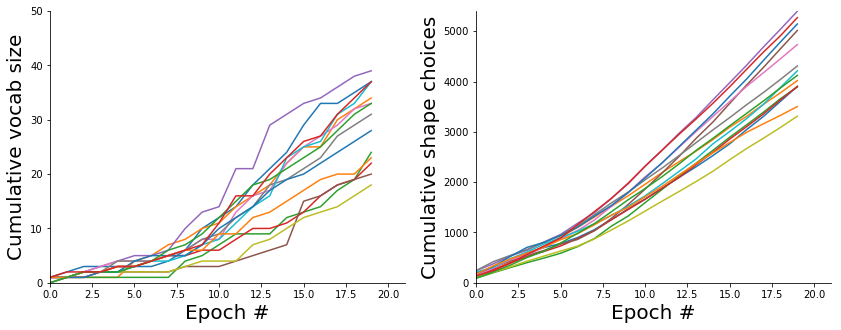

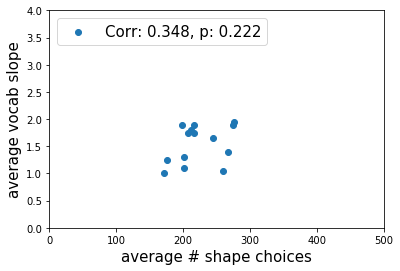

In [392]:
vocab_slopes, shape_choices = plot_first100nouns_new(
    folder='../results/vocab_accel_trio_500trials/', 
    nb_categories=48,
    nb_epoch=20,
    nb_test=500
)

## Try again with the 60-20-20 dataset

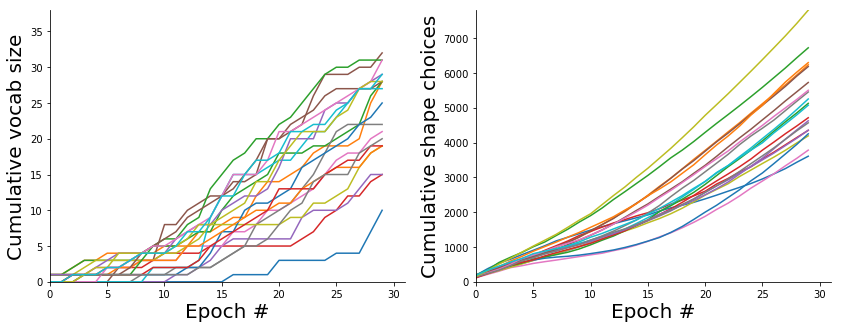

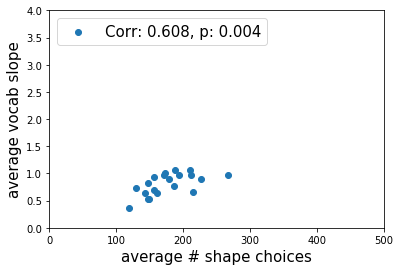

In [457]:
vocab_slopes, shape_choices = plot_first100nouns_new(
    folder='../results/vocab_accel_trio_602020/', 
    nb_categories=36,
    nb_epoch=30,
    nb_test=500
)

[ 4 14 18 11  2 16 13 19]


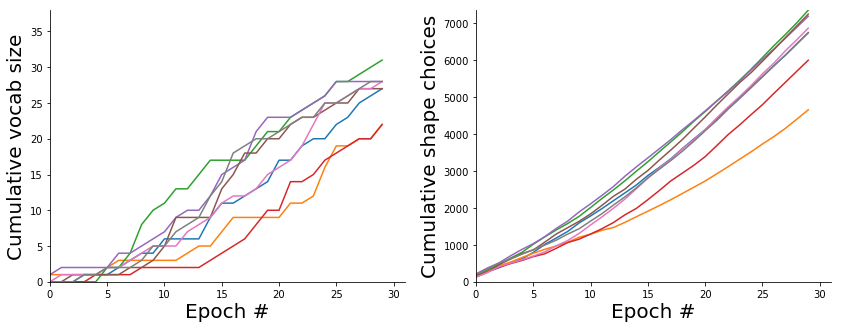

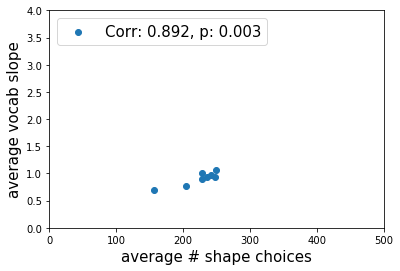

[18  1  7 12 10 14  3 13]


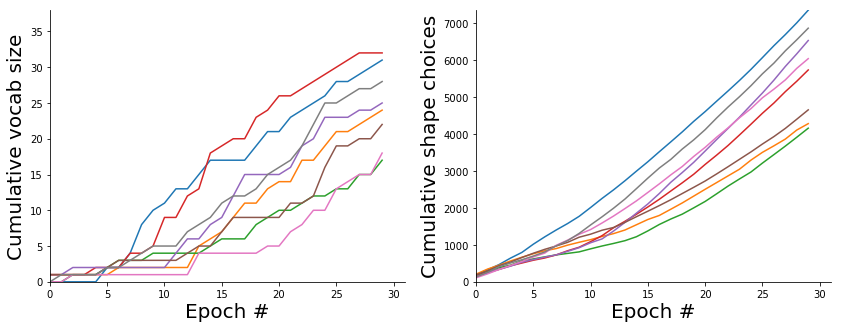

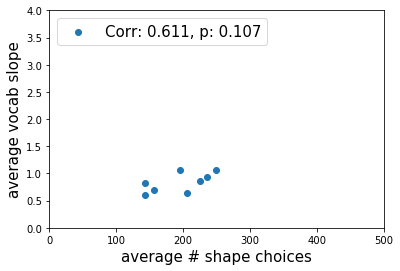

[10  9 13 17  2  4 15 12]


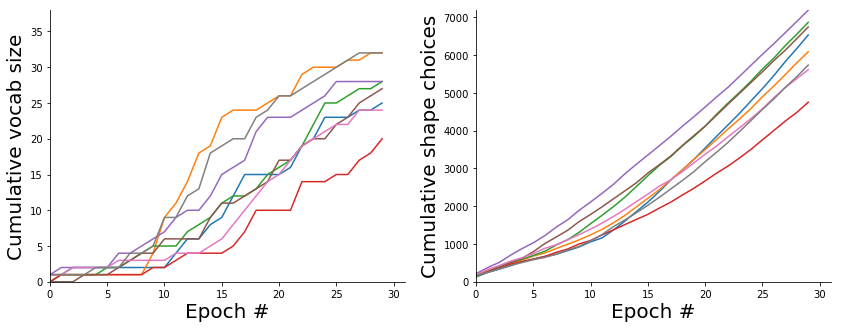

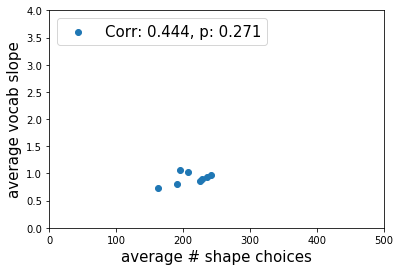

[11 13 12 18  4  3  1 17]


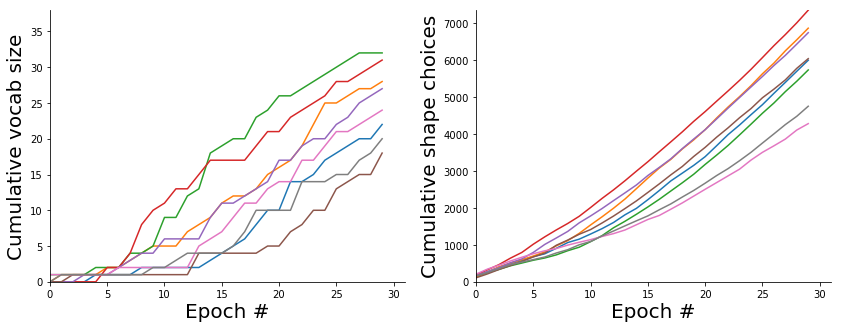

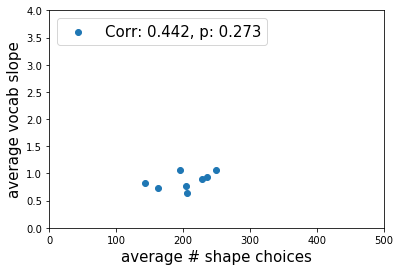

[11 14 18 12  5  1  2 17]


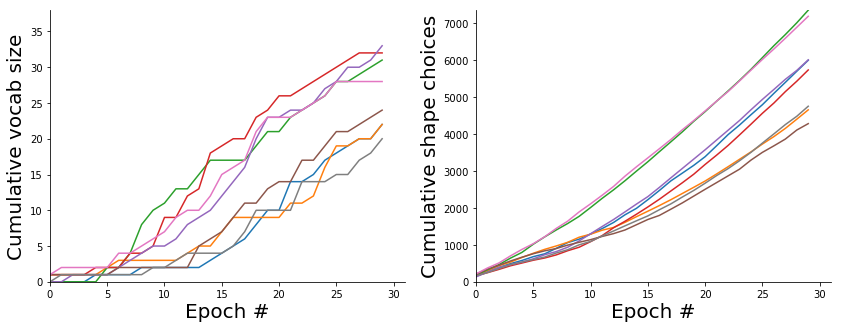

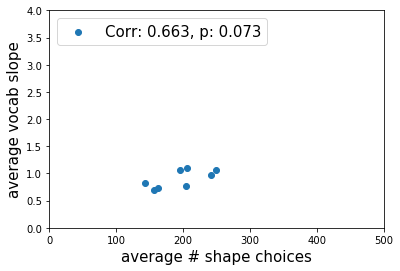

[ 7  6  8 12  2 18 19 16]


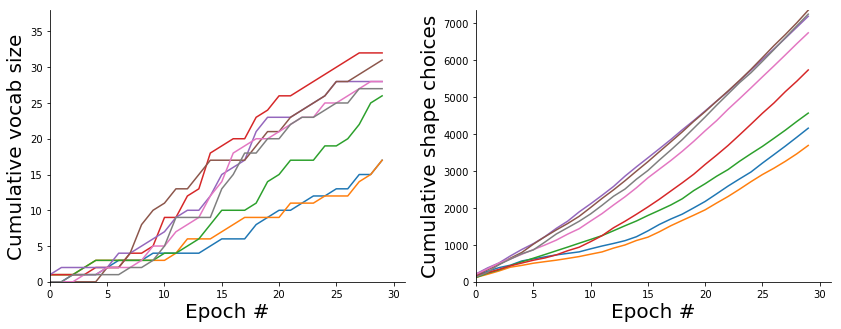

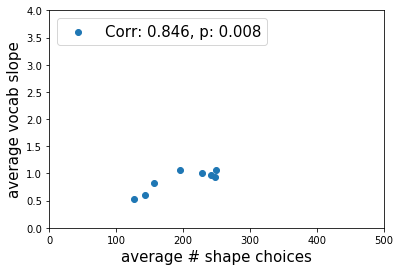

[ 3  0 13 11 18 14 19  5]


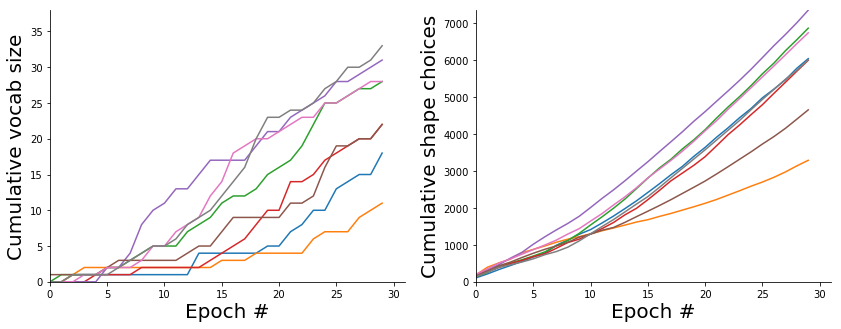

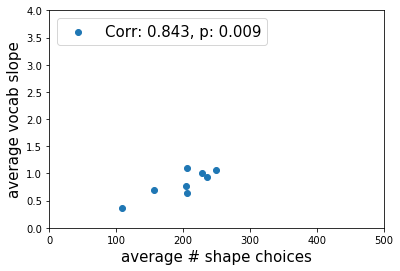

[ 2  4  5 13  6  3  0  9]


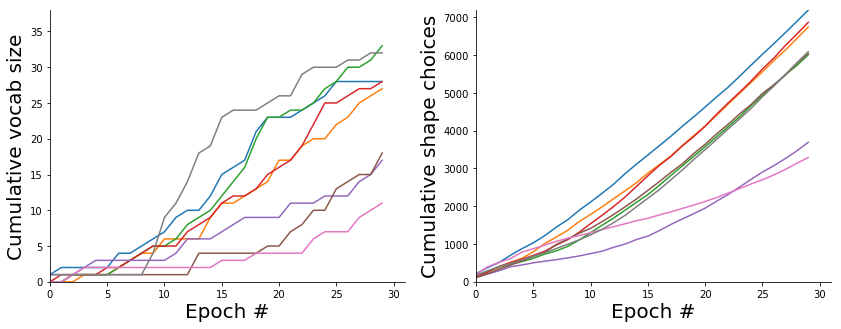

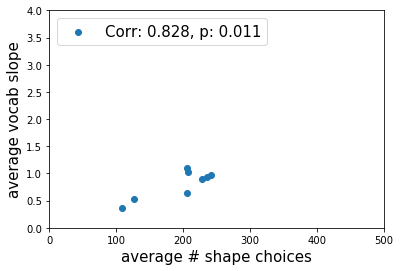

[10  0 14  4  6  8  3 18]


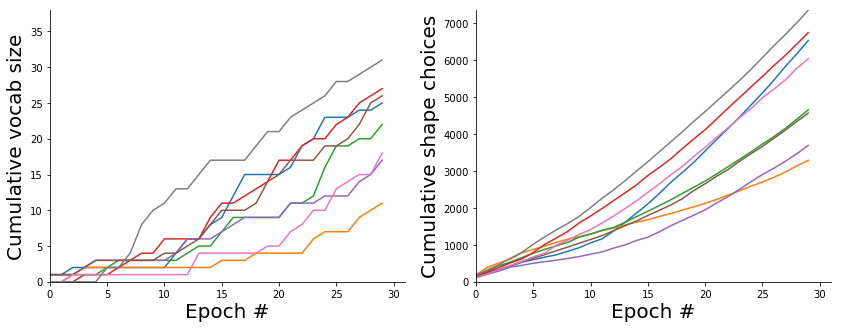

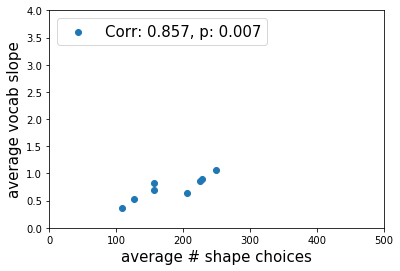

[17 18  2  3  1  9 13 12]


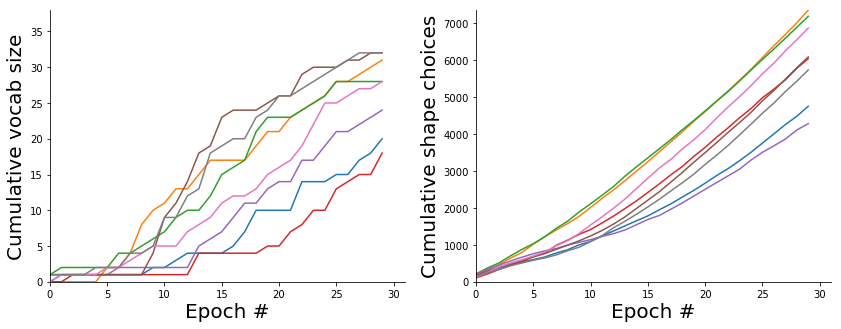

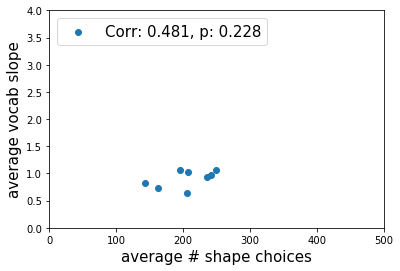

In [624]:
for i in range(10):
    file_inds = np.random.choice(range(20), 8, replace=False)
    print(file_inds)
    vocab_slopes, shape_choices = plot_first100nouns_new(
        folder='../results/vocab_accel_trio_602020_redo/', 
        nb_categories=36,
        nb_epoch=30,
        nb_test=500, 
        file_inds=file_inds
    )

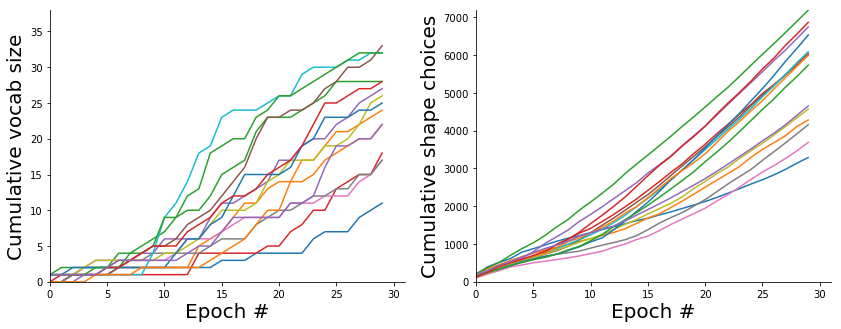

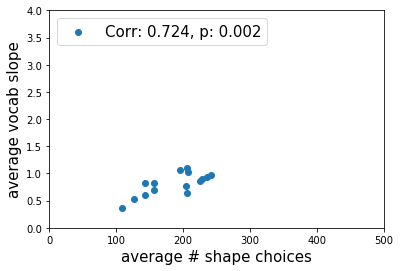

In [456]:
vocab_slopes, shape_choices = plot_first100nouns_new(
    folder='../results/vocab_accel_trio_602020_redo/', 
    nb_categories=36,
    nb_epoch=30,
    nb_test=500, 
    file_inds=[0, 1, 3, 4, 5, 7, 11, 14, 15]
)

# Ok... so we have a plan going forward. Look at first 20 training epochs, use 60-20-20 breakdown. Let's now compute Gershkoff-Stowe's other metrics.

## There are 3 metrics. Above, we looked at #2. Now, we will look at metric #1.

In [488]:
import itertools

def get_intervals(nb_epoch, nb_sessions):
    assert nb_epoch % nb_sessions == 0
    step = int(nb_epoch/nb_sessions)
    return [i*step for i in range(nb_sessions)]

def plot_corr2(file, nb_categories, nb_epoch, nb_sessions, nb_test, plot_growth=True):
    df = pd.read_csv(file, index_col=False)
    assert len(df) >= nb_epoch
    # compute session intervals
    intervals = get_intervals(nb_epoch, nb_sessions)
    # compute cumulative vocab and shape choices at the intervals
    o2_cumulative = np.asarray(list(itertools.accumulate(df.o2_correct)))
    c_vocab = df.vocabSize80_s.iloc[intervals]
    c_shape = o2_cumulative[intervals]
    if plot_growth:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
        # Vocab plot
        axes[0].plot(intervals, c_vocab, marker='o', markersize=10)
        axes[0].set_ylabel('Cumulative vocab size', fontsize=16)
        axes[0].set_ylim(0, int(0.75*nb_categories))
        # Shape choice plot
        axes[1].plot(intervals, c_shape, marker='o', markersize=10)
        axes[1].set_ylabel('Cumulative shape choices', fontsize=16)
        axes[1].set_ylim(0, nb_test*nb_epoch)
        for ax in axes:
            ax.set_xlabel('Session', fontsize=16)
            ax.set_xlim(0, nb_epoch)
            ax.set_xticks(intervals)
            ax.set_xticklabels(range(nb_sessions))
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
        plt.show()
    
    # compute gradients of cumulative values accross each interval
    vocab_slopes = [j-i for i, j in zip(c_vocab[:-1], c_vocab[1:])]
    shape_slopes = [j-i for i, j in zip(c_shape[:-1], c_shape[1:])]
    # Compute correlation and plot
    corr, p = pearsonr(vocab_slopes, shape_slopes)
    plt.figure(figsize=(6,4))
    plt.scatter(shape_slopes, vocab_slopes, label='r: %0.3f, p: %0.3f' % (corr, p))
    plt.xlabel('shape slope', fontsize=15)
    plt.ylabel('vocab slope', fontsize=15)
    plt.xlim(0, (nb_epoch/nb_sessions)*nb_test)
    plt.ylim(-1, 1.5*(nb_epoch/nb_sessions))
    plt.legend(fontsize=15, loc='lower right')
    plt.show()
    
    return corr, p

In [496]:
folder = '../results/vocab_accel_trio_602020/'
files = sorted(
    [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.csv')]
)

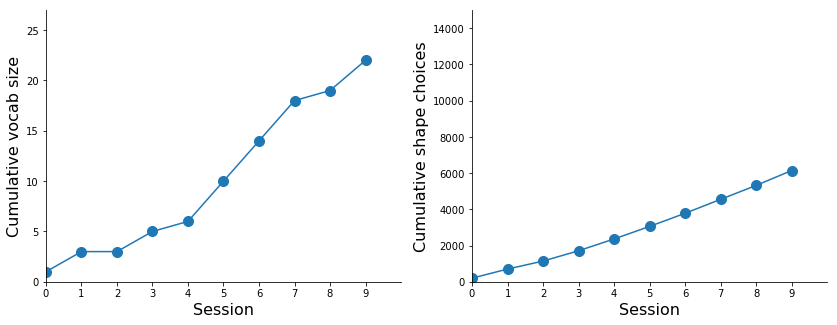

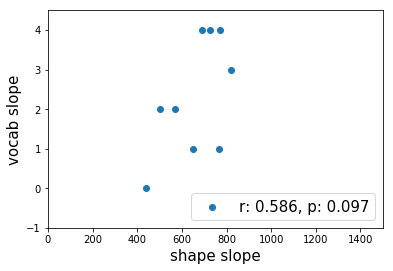

In [489]:
_, _ = plot_corr2(
    file=files[2], 
    nb_categories=36,
    nb_epoch=30,
    nb_sessions=10,
    nb_test=500
)

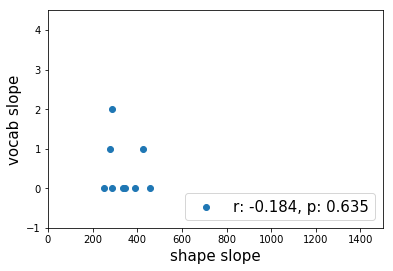

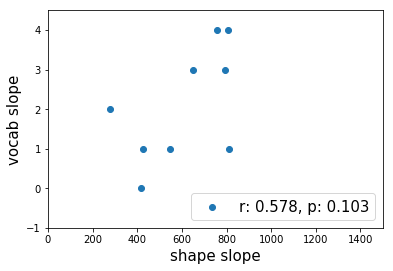

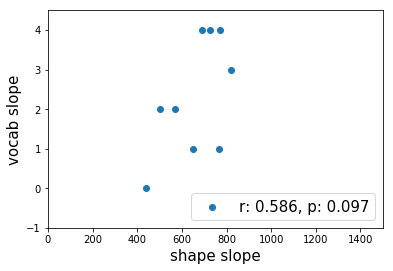

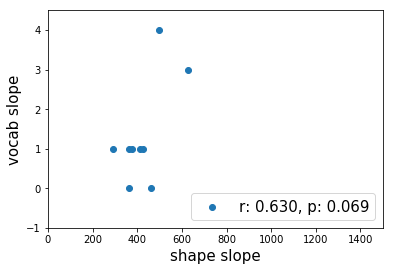

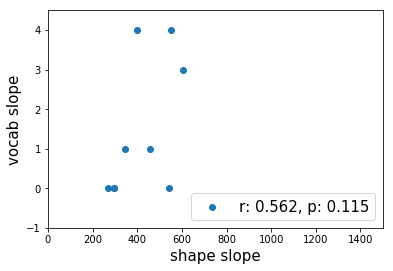

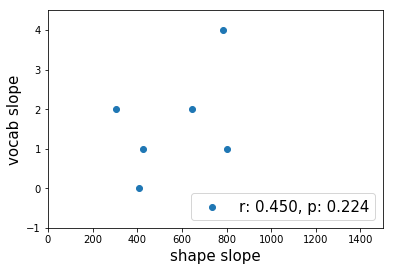

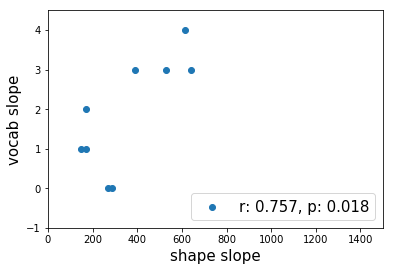

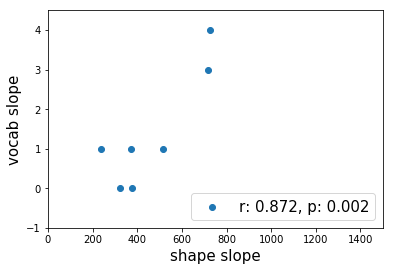

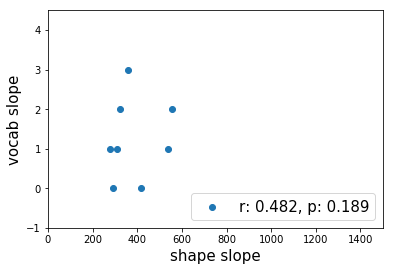

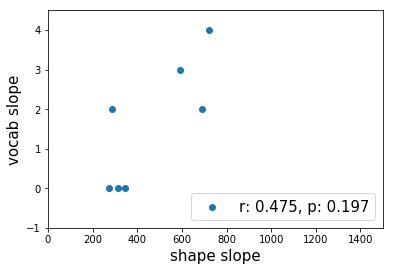

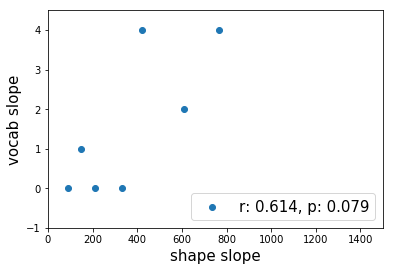

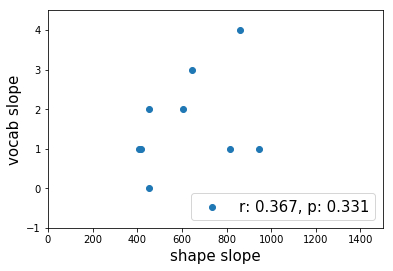

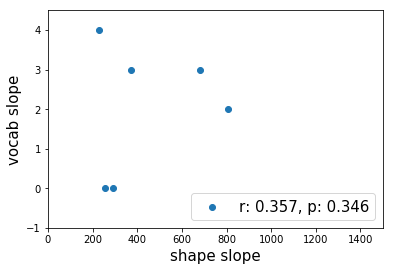

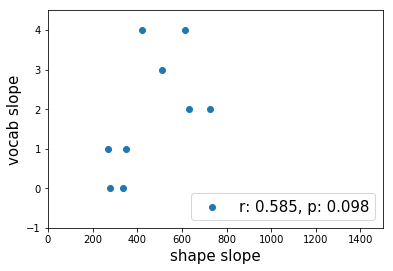

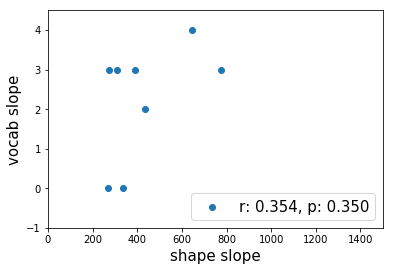

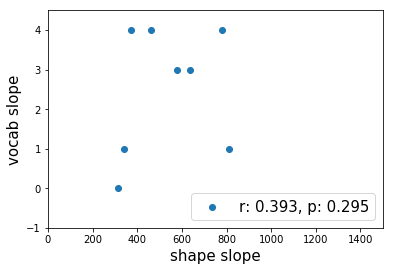

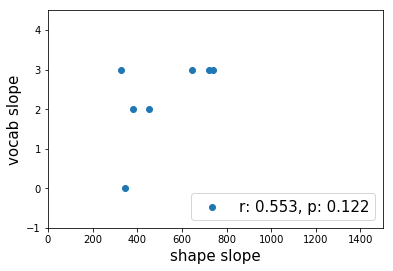

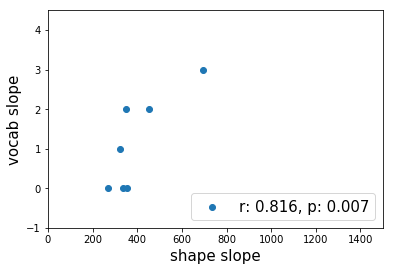

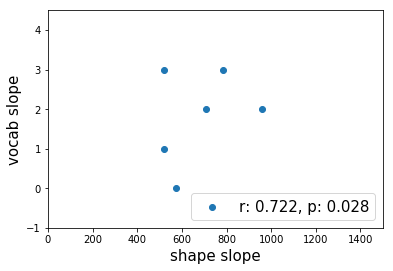

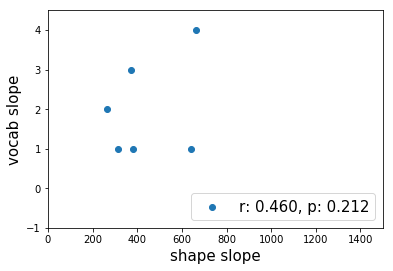

In [499]:
count = 0
for i in range(len(files)):
    corr, p = plot_corr2(
        file=files[i], 
        nb_categories=36,
        nb_epoch=30,
        nb_sessions=10,
        nb_test=500,
        plot_growth=False
    )
    if corr >= 0.5 and p <= 0.1:
        count += 1

In [680]:
folder = '../results/vocab_accel_trio_602020_redo/'
files = sorted(
    [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.csv')]
)

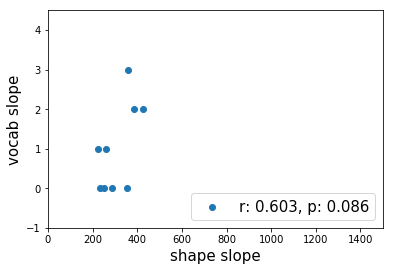

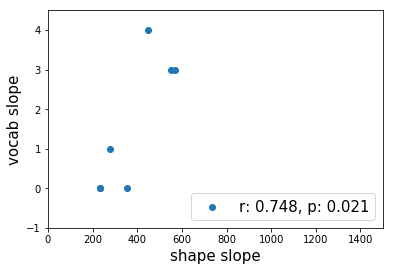

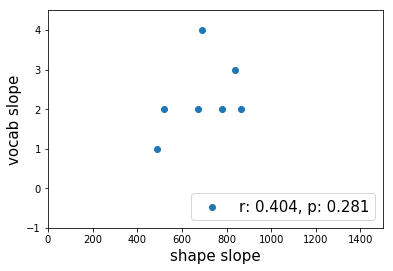

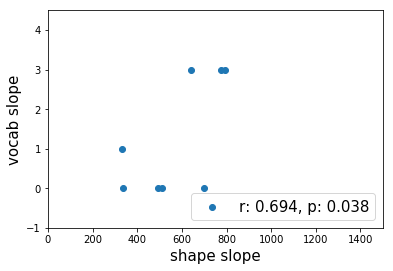

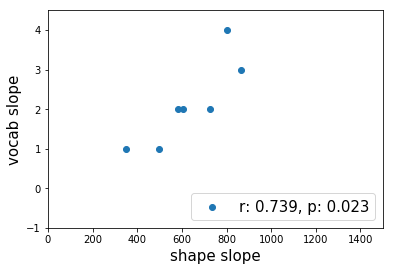

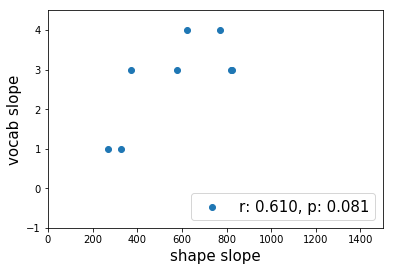

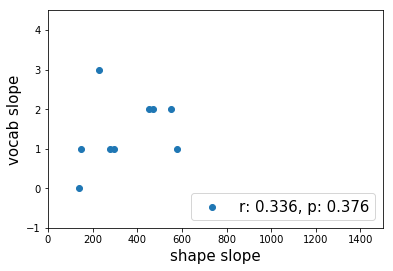

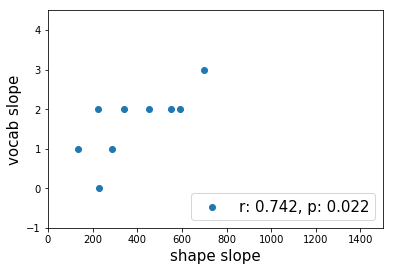

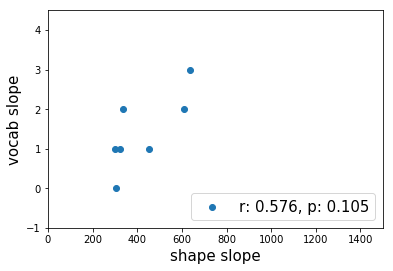

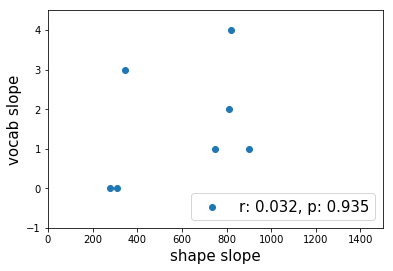

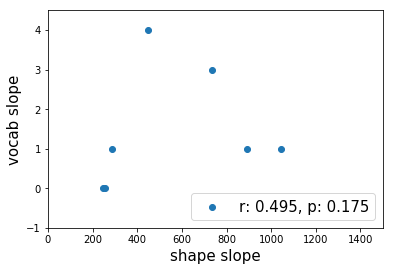

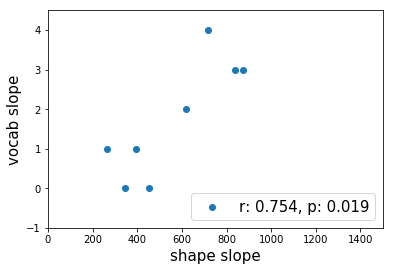

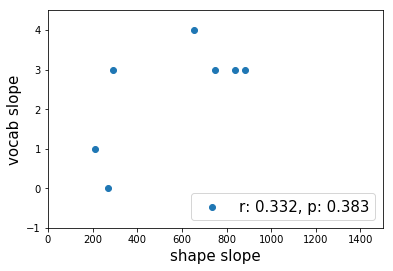

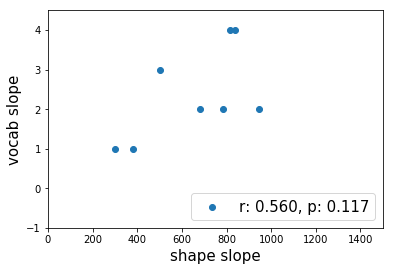

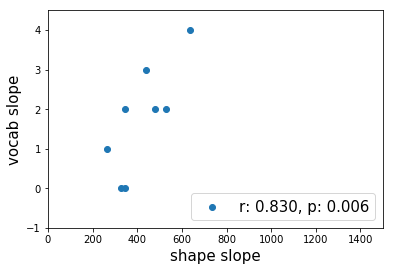

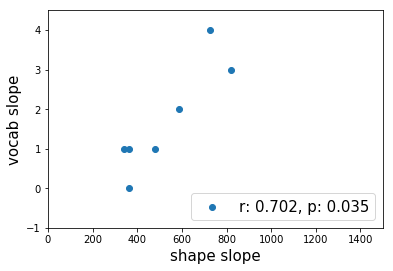

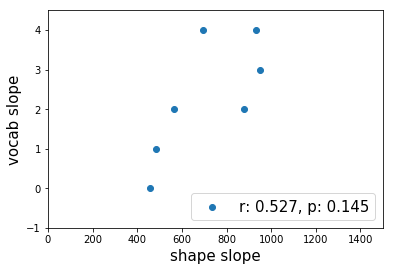

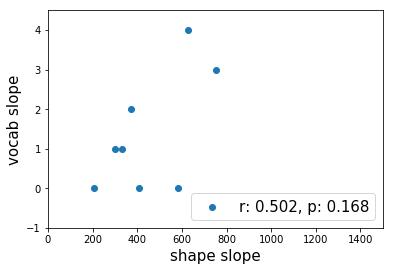

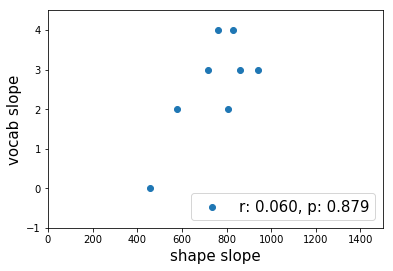

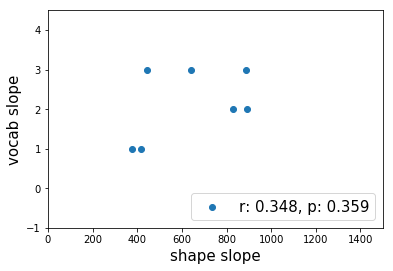

In [687]:
inds = []
corrs = np.zeros(len(files))
for i in range(len(files)):
    corr, p = plot_corr2(
        file=files[i], 
        nb_categories=36,
        nb_epoch=30,
        nb_sessions=10,
        nb_test=500,
        plot_growth=False
    )
    corrs[i] = corr
    if p <= 0.1:
        inds.append(i)

In [688]:
corrs[inds].mean()

0.71354627780523261

In [682]:
inds

[0, 1, 3, 4, 5, 7, 11, 14, 15]

# Now let's do the 3rd metric

In [553]:
def plot_corr3(folder, nb_categories, nb_epoch, nb_sessions, nb_test, 
               threshold_v, threshold_s, plot_growth=True):
    files = sorted(
        [file for file in os.listdir(folder) if file.endswith('.csv')]
    )
    # compute session intervals
    intervals = get_intervals(nb_epoch, nb_sessions)
    v_turns = []
    s_turns = []
    for file in files:
        df = pd.read_csv(os.path.join(folder, file), index_col=False)
        assert len(df) >= nb_epoch
        # compute cumulative vocab and shape choices at the intervals
        o2_cumulative = np.asarray(list(itertools.accumulate(df.o2_correct)))
        c_vocab = df.vocabSize80_s.iloc[intervals]
        c_shape = o2_cumulative[intervals]
        # compute gradients of cumulative values accross each interval
        vocab_slopes = np.asarray([j-i for i, j in zip(c_vocab[:-1], c_vocab[1:])])
        shape_slopes = np.asarray([j-i for i, j in zip(c_shape[:-1], c_shape[1:])])
        turn_v = np.where(vocab_slopes >= threshold_v)[0]
        turn_s = np.where(shape_slopes >= threshold_s)[0]
        if len(turn_v) > 0 and len(turn_s) > 0:
            #print('turn_v: %i' % turn_v[0])
            #print('turn_s: %i\n' % turn_s[0])
            v_turns.append(turn_v[0])
            s_turns.append(turn_s[0])
        if plot_growth:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
            # Vocab plot
            axes[0].plot(intervals, c_vocab, marker='o', markersize=10)
            axes[0].set_ylabel('Cumulative vocab size', fontsize=16)
            axes[0].set_ylim(0, int(0.75*nb_categories))
            # Shape choice plot
            axes[1].plot(intervals, c_shape, marker='o', markersize=10)
            axes[1].set_ylabel('Cumulative shape choices', fontsize=16)
            axes[1].set_ylim(0, nb_test*nb_epoch)
            for ax in axes:
                ax.set_xlabel('Session', fontsize=16)
                ax.set_xlim(0, nb_epoch)
                ax.set_xticks(intervals)
                ax.set_xticklabels(range(nb_sessions))
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
            plt.show()
            print('\n')
        
    # Compute correlation and plot
    corr, p = pearsonr(v_turns, s_turns)
    plt.figure(figsize=(6,4))
    plt.scatter(v_turns, s_turns, label='r: %0.3f, p: %0.3f' % (corr, p))
    plt.xlabel('shape-bias session', fontsize=15)
    plt.ylabel('rate-shift session', fontsize=15)
    plt.xlim(-1, nb_sessions)
    plt.ylim(-1, nb_sessions)
    plt.legend(fontsize=15, loc='lower right')
    plt.show()
    
    return corr, p

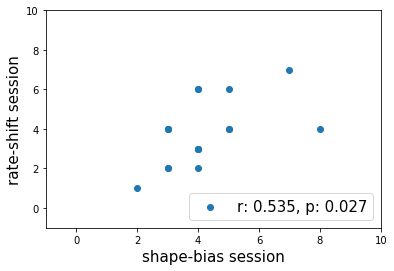

In [679]:
_, _ = plot_corr3(
    folder='../results/vocab_accel_trio_602020_redo/', 
    nb_categories=36,
    nb_epoch=30,
    nb_sessions=10,
    nb_test=500,
    threshold_v = 4,
    threshold_s = 180*3,
    plot_growth=False
)

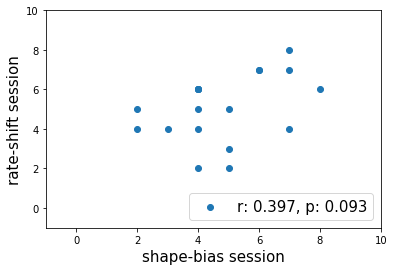

In [676]:
_, _ = plot_corr3(
    folder='../results/vocab_accel_trio_602020/', 
    nb_categories=36,
    nb_epoch=30,
    nb_sessions=10,
    nb_test=500,
    threshold_v = 4,
    threshold_s = 180*3,
    plot_growth=False
)

In [661]:
def plot_fig5and6(folder, nb_categories, nb_epoch, nb_sessions, nb_test, 
                  file_inds=None, axis_fs=16, tick_fs=14, save=False):
    files = sorted(
        [file for file in os.listdir(folder) if file.endswith('.csv')]
    )
    if file_inds is not None:
        files = [files[i] for i in file_inds]
    # compute session intervals
    intervals = get_intervals(nb_epoch, nb_sessions)
    # start fig plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for i, file, marker in zip(range(len(files)), files, itertools.cycle('o^+*s')):
        df = pd.read_csv(os.path.join(folder, file), index_col=False)
        assert len(df) >= nb_epoch
        # compute cumulative vocab and shape choices at the intervals
        o2_cumulative = np.asarray(list(itertools.accumulate(df.o2_correct)))
        c_vocab = df.vocabSize80_s.iloc[intervals]
        c_shape = o2_cumulative[intervals]
        if i % 2 == 0:
            # plot with hollow marker
            axes[0].plot(intervals, c_vocab, marker=marker, markersize=10, 
                         markerfacecolor='none')
            axes[1].plot(intervals, c_shape, marker=marker, markersize=10, 
                         markerfacecolor='none')
        else:
            # plot with solid marker
            axes[0].plot(intervals, c_vocab, marker=marker, markersize=10)
            axes[1].plot(intervals, c_shape, marker=marker, markersize=10)
    axes[0].set_ylabel('Cumulative count nouns', fontsize=axis_fs)
    axes[0].set_yticks(np.arange(0,31,5))
    axes[0].set_yticklabels(np.arange(0,31,5), fontsize=tick_fs)
    axes[1].set_ylabel('Cumulative shape choices', fontsize=axis_fs)
    axes[1].set_yticks(np.arange(0, 7001, 1000))
    axes[1].set_yticklabels(np.arange(0, 7001, 1000), fontsize=tick_fs)
    for ax in axes:
        ax.set_xlabel('Session', fontsize=axis_fs)
        ax.set_xlim(-3, nb_epoch)
        ax.set_xticks(intervals)
        ax.set_xticklabels(range(1, nb_sessions+1), fontsize=tick_fs)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.subplots_adjust(wspace=0.2)
    if save:
        plt.savefig(
            '../../cogsci-paper/figures/shape_and_vocab.pdf',
            format='pdf',
            bbox_inches='tight'
        )
    else:
        plt.show()

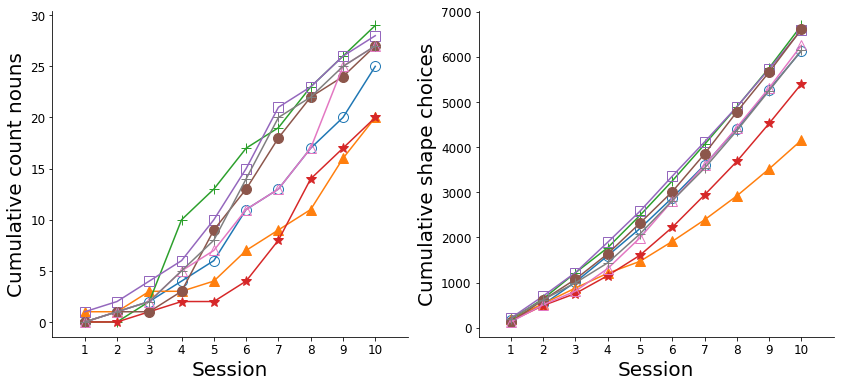

In [662]:
plot_fig5and6(
    folder='../results/vocab_accel_trio_602020_redo/', 
    nb_categories=36,
    nb_epoch=30,
    nb_sessions=10,
    nb_test=500,
    file_inds=[4, 14, 18, 11, 2, 16, 13, 19],
    #file_inds=[0, 1, 3, 4, 5, 7, 11, 14, 15],
    axis_fs=20,
    tick_fs=12,
    save=True
)